In [1]:
import torch 
from sbi.analysis import pairplot

import matplotlib.pyplot as plt

from rbi.utils.datasets import get_datasets, get_reference_simulator, get_HH_prior, syn_current
from rbi.utils.nets import AffineAutoregressiveModel
from rbi.loss.loss_fn import NLLLoss
import numpy as np

In [2]:
train_loader, test_loader = get_datasets("hudgin_huxley_inverse", N_train=50000, N_test=10000, batch_size=1000)
ref_simulator = get_reference_simulator("hudgin_huxley")
prior = get_HH_prior()

In [3]:
# Good figure
from tueplots import bundles
for X,y in train_loader:
    break

In [4]:
t = torch.linspace(0, 120, 201)

In [5]:
I, t_on, t_off, _, _, A_soma = syn_current()

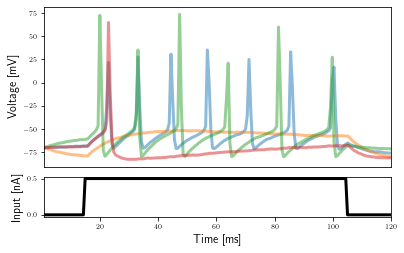

In [70]:
i = 122
with plt.rc_context(bundles.neurips2022(nrows=2, ncols=2)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,0.5]})
    axes[0].plot(t,X[i:i+4].T, alpha=0.5, lw=3)
    axes[0].set_xlim(0, 120)
    axes[1].set_xlim(1, 120)
    axes[0].set_xticks([])
    axes[1].plot(t,I[::20]*A_soma*1e3, color="black", lw=3)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[1].set_ylabel("Input [nA]", fontsize=12)
    fig.savefig("hh_model.svg")

In [6]:
from torch.distributions import AffineTransform, SigmoidTransform, ComposeTransform
a = prior.support.base_constraint.lower_bound
b = prior.support.base_constraint.upper_bound 
dist = b-a

out_t = ComposeTransform([SigmoidTransform(), AffineTransform(a, dist)])

In [32]:
net = AffineAutoregressiveModel(201, 7, num_transforms=5, shuffle=True, hidden_dims=[200, 200], output_transform=out_t, inverse_flow=True, embedding_net=torch.nn.Sequential(torch.nn.Linear(201,100), torch.nn.ReLU(), torch.nn.Linear(100, 10)))
loss_fn = NLLLoss(net)

In [352]:
#net.distribution = torch.load("nn.pkl")

In [353]:
from pyro.distributions import TransformModule

In [33]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

for i in range(30):
    l = 0
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 5.)
        optim.step()
        l += loss.detach()/100
    print(l)

tensor(9.2950)
tensor(6.8395)
tensor(6.6005)
tensor(6.4239)
tensor(6.2927)
tensor(6.1601)
tensor(6.1026)
tensor(6.0446)
tensor(5.9311)
tensor(5.9639)
tensor(5.7574)
tensor(5.7931)
tensor(5.6555)
tensor(5.5269)
tensor(5.5455)
tensor(5.3416)
tensor(5.4519)
tensor(5.4462)
tensor(5.2815)
tensor(5.2636)
tensor(5.2581)
tensor(5.2956)
tensor(5.2336)
tensor(5.1718)
tensor(5.0485)
tensor(5.0369)
tensor(4.9119)
tensor(4.9283)
tensor(4.8689)
tensor(4.9385)


In [140]:
for X_test, y_test in train_loader:
    break 

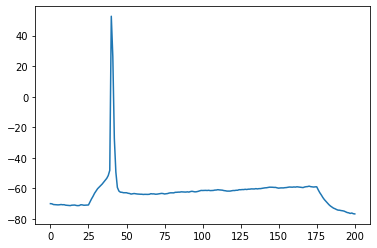

In [141]:
for X_test, y_test in train_loader:
    break 
x_obs = X_test[0]
plt.plot(x_obs)

In [417]:
p = net(x_obs.unsqueeze(0))
samples = p.sample((20000,))

(<Figure size 720x720 with 49 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 5'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:xlabel='dim 6'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <A

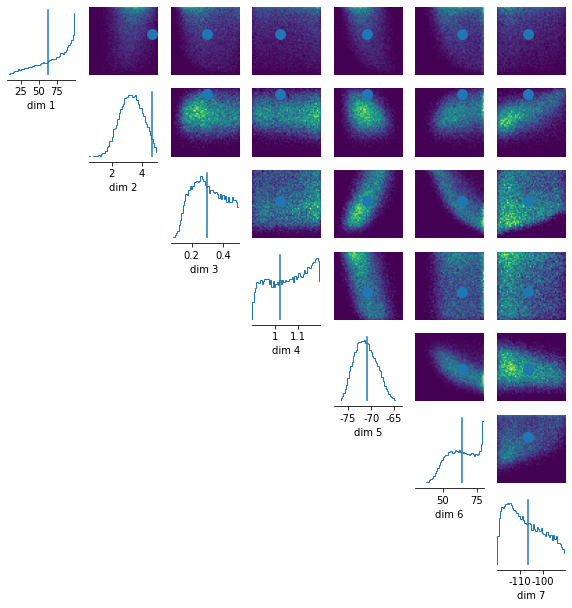

In [418]:
pairplot(samples.squeeze(), points = y_test[0])

In [419]:
states = ref_simulator(samples.squeeze(), dt=0.03)

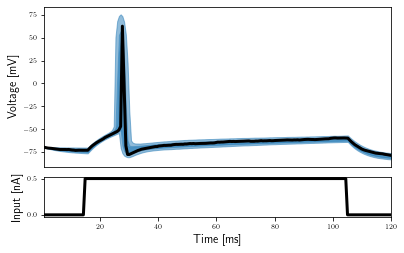

In [420]:
with plt.rc_context(bundles.neurips2022(nrows=2, ncols=2)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,0.5]})
    ds = []
    for i in range(10000):
        d = states[:, i, 0][::20]
        ds.append(d)
    for c in [0.2, 0.1, 0.01]:
        q_10 = torch.stack(ds).quantile(c, dim=0)
        q_90 = torch.stack(ds).quantile(1-c, dim=0)
        axes[0].fill_between(t,q_10, q_90, alpha=0.5-c, color="C0")
    axes[0].plot(t,X_test[0], color="black", lw=3)
    axes[0].set_xlim(0, 120)
    axes[1].set_xlim(1, 120)
    axes[0].set_xticks([])
    axes[1].plot(t,I[::20]*A_soma*1e3, color="black", lw=3)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[1].set_ylabel("Input [nA]", fontsize=12)
    fig.savefig("posterior_predictive_x_o.svg")

In [8]:
from rbi.attacks.advertorch_attack import LinfPGDAttack, L2PGDAttack, L1PGDAttack, L2MomentumIterativeAttack
from rbi.loss.loss_fn import ForwardKLLoss, LogLikelihoodLoss, ReverseKLLoss, NegativeLogLikelihoodLoss

In [9]:
adversarial_loss = ForwardKLLoss()

In [10]:
adversarial_loss2  = LogLikelihoodLoss()

In [11]:
import torch 
from torch import Tensor
from torch.distributions import Distribution, kl_divergence, register_kl, TransformedDistribution

from typing import Optional, Tuple, List, Callable
from rbi.loss.base import TrainLoss, EvalLoss


MC_SAMPLES = 256
@register_kl(Distribution, Distribution)
def general_kl_divergence(p, q):
    global MC_SAMPLES
    samples = p.rsample((MC_SAMPLES,))
    logp = p.log_prob(samples)
    logq = q.log_prob(samples)
    return torch.mean(logp-logq, 0)

@register_kl(TransformedDistribution, TransformedDistribution)
def general_kl_divergence(p, q):
    global MC_SAMPLES
    samples = p.rsample((MC_SAMPLES,))
    logp = p.log_prob(samples)
    logq = q.log_prob(samples)
    return torch.mean(logp-logq, 0)

class ReverseKLLoss(EvalLoss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)
    
    def _loss(self, output: Distribution, target: Distribution) -> Tensor:

        if not isinstance(output, Distribution):
            # If parameters are returned than make a distribution out of them
            output = self.model.generator(output)

        if not isinstance(target, Distribution):
            raise ValueError(r"The target must be a distribution...")

        return torch.mean(kl_divergence(output, target))



In [12]:
adversarial_loss3 = ReverseKLLoss()

In [13]:
adversarial_loss4 = NegativeLogLikelihoodLoss()

In [14]:
attack = L2PGDAttack(net, adversarial_loss3, eps=60., nb_iter=100, eps_iter=10.)

In [424]:
perturbed = attack.perturb(X_test[:1])

In [425]:
from rbi.utils.fisher_info import monte_carlo_fisher

Fs = monte_carlo_fisher(perturbed.repeat(10,1), net, mc_samples=1000, create_graph=False).mean(0)
Fs_test = monte_carlo_fisher(X_test[:1].repeat(10,1), net, mc_samples=1000, create_graph=False).mean(0)

In [426]:
torch.linalg.eigvalsh(Fs).max(-1)

torch.return_types.max(
values=tensor(576.2241),
indices=tensor(200))

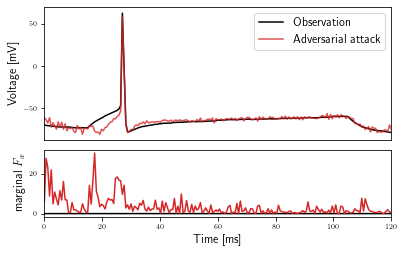

In [427]:
with plt.rc_context(bundles.neurips2022(nrows=1, ncols=1)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,1]})
    axes[0].plot(t,X_test[0], color="black")
    axes[0].plot(t,perturbed[0], color="C3", alpha=0.8)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[0].legend(["Observation", "Adversarial attack"], fontsize=12)
    axes[0].set_xlim(0, 120)
    axes[0].set_xticks([])

    axes[1].plot(t,torch.diagonal(Fs_test, dim1=-2, dim2=-1).detach(), color="black")
    axes[1].plot(t,torch.diagonal(Fs, dim1=-2, dim2=-1).detach(), color="C3")
    axes[1].set_xlim(0, 120)
    axes[1].set_ylabel(r"marginal $F_x$", fontsize=12)

    fig.savefig("adversarial_HH_example.svg")

c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels

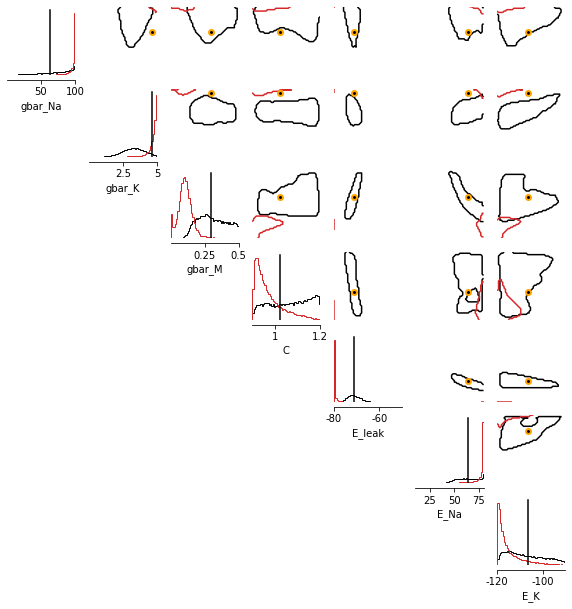

In [431]:
samples2 = net(perturbed[0]).sample((30000,))
fig = pairplot([samples.squeeze(), samples2.squeeze()], points = y_test[0], limits=[(a[i], b[i] ) for i in range(len(a))], upper="contour", samples_colors=["black", "C3"], points_colors=["black"], labels=["gbar_Na", "gbar_K", "gbar_M", "C", "E_leak", "E_Na", "E_K"], scatter_offdiag={"s": 2., "alpha":0.1}, hist_diag={"density":True}, points_offdiag={"marker":"o", "markersize":5, "markeredgewidth":2,"markeredgecolor":'orange'})
fig[0].savefig("pairplot_adversarial_posterior_scatter.svg")

In [432]:
states = ref_simulator(samples2.squeeze(), dt=0.03)

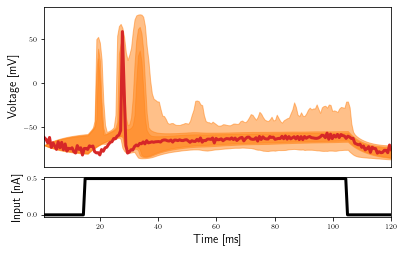

In [433]:
with plt.rc_context(bundles.neurips2022(nrows=2, ncols=2)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,0.5]})
    for i in range(10000):
        d = states[:, i, 0][::20]
        ds.append(d)
    for c in [0.1, 0.05, 0.01]:
        q_10 = torch.stack(ds).quantile(c, dim=0)
        q_90 = torch.stack(ds).quantile(1-c, dim=0)
        axes[0].fill_between(t,q_10, q_90, alpha=0.5-c, color="C1")
    axes[0].plot(t,perturbed[0], color="C3", lw=3)
    axes[0].set_xlim(0, 120)
    axes[1].set_xlim(1, 120)
    axes[0].set_xticks([])
    axes[1].plot(t,I[::20]*A_soma*1e3, color="black", lw=3)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[1].set_ylabel("Input [nA]", fontsize=12)
    fig.savefig("posterior_predictive_adversarial_example.svg")

In [15]:
from rbi.defenses.regularized_loss import GaussianNoiseTransformRegularizer, GaussianNoiseJacobiRegularizer
from rbi.utils.transforms import get_transform_jacobian
from rbi.utils.fisher_info import monte_carlo_diagonal_fisher, monte_carlo_fisher

In [47]:
net2 = AffineAutoregressiveModel(201, 7, num_transforms=5, shuffle=True, hidden_dims=[200, 200], output_transform=out_t, inverse_flow=True, embedding_net=torch.nn.Sequential(torch.nn.Linear(201,100), torch.nn.ReLU(), torch.nn.Linear(100, 10)))


In [48]:
loss_fn = NLLLoss(net2)

In [127]:
#torch.save(net2.distribution, "fisher_reg_nn2.pkl")

In [440]:
# net2.distribution = torch.load("fisher_reg_nn2.pkl")

In [202]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-5)

for i in range(10):
    l = 0
    r = 0
    for X,Y in train_loader:
        optim.zero_grad()
        reg = 200*torch.linalg.norm(monte_carlo_diagonal_fisher(X[:100],net2, create_graph=True, mc_samples=200), dim=-1).mean(0)
        loss = loss_fn(X,Y) + (reg - reg.detach())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net2.parameters(), 5.)
        optim.step()
        l += loss.detach()
        r += reg.detach()
    print(l/100)
    print(r/100)

tensor(5.8162)
tensor(0.2182)
tensor(5.8251)
tensor(0.2056)
tensor(5.8238)
tensor(0.2032)
tensor(5.8242)
tensor(0.2017)
tensor(5.8223)
tensor(0.1999)
tensor(5.8233)
tensor(0.1995)
tensor(5.8182)
tensor(0.1987)
tensor(5.8191)
tensor(0.1987)
tensor(5.8139)
tensor(0.1973)
tensor(5.8122)
tensor(0.1976)


In [142]:
p = net2(x_obs.unsqueeze(0))
samples_F = p.sample((10000,))

In [614]:
torch.save(net.state_dict(), "state_dict_nn.pkl")

In [616]:
torch.save(net2.state_dict(), "regularized_state_dict_nn.pkl")

In [17]:
state_dict1 = torch.load("state_dict_nn.pkl")
state_dict2 = torch.load("regularized_state_dict_nn.pkl")

In [19]:
#net.load_state_dict(state_dict1)

<All keys matched successfully>

In [20]:
#net2.load_state_dict(state_dict2)

<All keys matched successfully>

(<Figure size 720x720 with 49 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 5'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:xlabel='dim 6'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <A

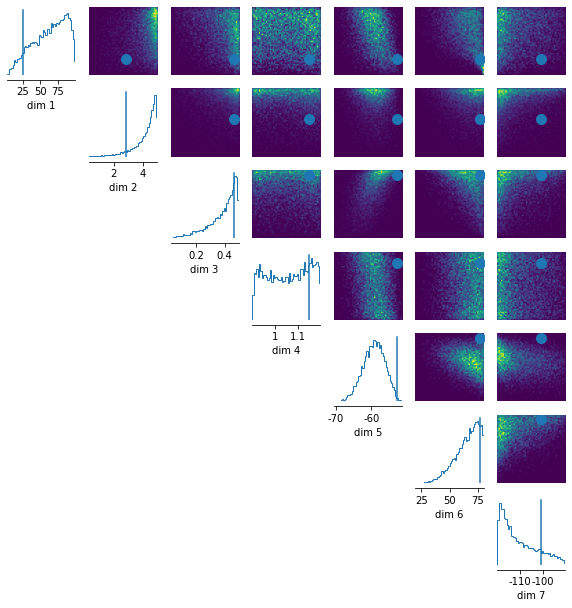

In [137]:
pairplot(samples_F.squeeze(), points = y[0])

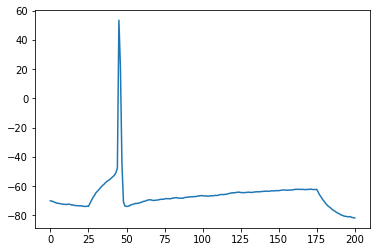

In [183]:
for X_test, y_test in train_loader:
    break 
x_obs = X_test[0]
plt.plot(x_obs)

In [184]:
p = net2(x_obs.unsqueeze(0))
samples_F = p.sample((10000,))

In [185]:
states_F = ref_simulator(samples_F.squeeze(), dt=0.03)

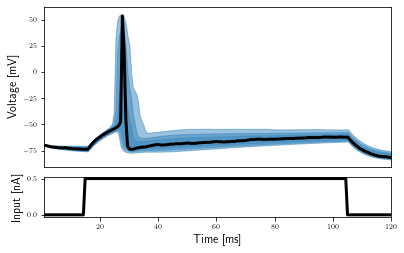

In [187]:
with plt.rc_context(bundles.neurips2022(nrows=2, ncols=2)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,0.5]})
    ds = []
    for i in range(10000):
        d = states_F[:, i, 0][::20]
        ds.append(d)
    for c in [0.2, 0.1, 0.05]:
        q_10 = torch.stack(ds).quantile(c, dim=0)
        q_90 = torch.stack(ds).quantile(1-c, dim=0)
        axes[0].fill_between(t,q_10, q_90, alpha=0.5-c, color="C0")
    axes[0].plot(t,X_test[0], color="black", lw=3)
    axes[0].set_xlim(0, 120)
    axes[1].set_xlim(1, 120)
    axes[0].set_xticks([])
    axes[1].plot(t,I[::20]*A_soma*1e3, color="black", lw=3)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[1].set_ylabel("Input [nA]", fontsize=12)
    fig.savefig("regularized_posterior_predictive_x_o.svg")

In [195]:
attack = L2PGDAttack(net2, adversarial_loss3, eps=65., nb_iter=100, eps_iter=1.)

In [146]:
perturbed_F = perturbed

NameError: name 'perturbed' is not defined

In [196]:
perturbed_F = attack.perturb(X_test[:1])

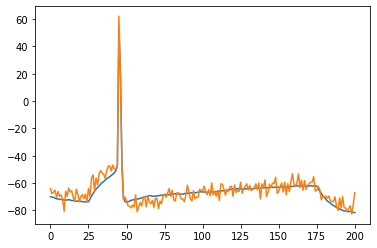

In [197]:
plt.plot(X_test[0])
plt.plot(perturbed_F[0])

In [177]:
Fs_F = monte_carlo_fisher(perturbed_F.repeat(10,1), net2, mc_samples=500, create_graph=False).mean(0)
Fs_test_F = monte_carlo_fisher(X_test[:1].repeat(10,1), net2, mc_samples=500, create_graph=False).mean(0)

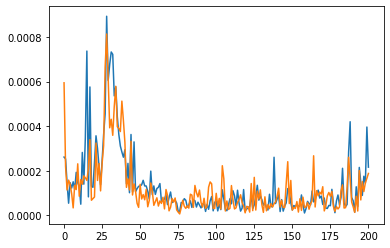

In [198]:
plt.plot(Fs_test_F.diag())
plt.plot(Fs_F.diag())

c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels

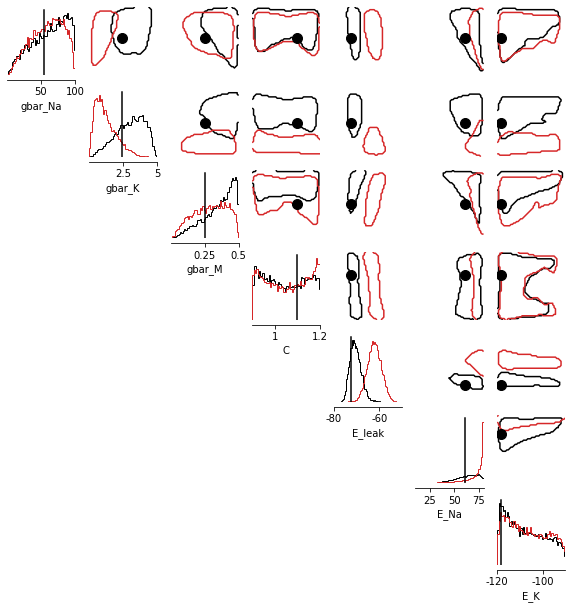

In [199]:
samples2_F = net2(perturbed_F[0]).sample((10000,))

fig = pairplot([samples_F.squeeze(), samples2_F.squeeze()], points = y_test[0], limits=[(a[i], b[i] ) for i in range(len(a))], upper="contour", samples_colors=["black", "C3"], points_colors=["black"], labels=["gbar_Na", "gbar_K", "gbar_M", "C", "E_leak", "E_Na", "E_K"])
#fig[0].savefig("regularized_pairplot_adversarial_posterior.svg")

In [200]:
states_F2 = ref_simulator(samples2_F.squeeze(), dt=0.03)

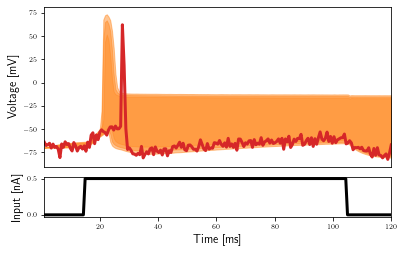

In [201]:
with plt.rc_context(bundles.neurips2022(nrows=2, ncols=2)):
    fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2,0.5]})
    ds = []
    for i in range(10000):
        d = states_F2[:, i, 0][::20]
        ds.append(d)
    for c in [0.2, 0.1, 0.05]:
        q_10 = torch.stack(ds).quantile(c, dim=0)
        q_90 = torch.stack(ds).quantile(1-c, dim=0)
        axes[0].fill_between(t,q_10, q_90, alpha=0.5-c, color="C1")
    axes[0].plot(t,perturbed_F[0], color="C3", lw=3)
    axes[0].set_xlim(0, 120)
    axes[1].set_xlim(1, 120)
    axes[0].set_xticks([])
    axes[1].plot(t,I[::20]*A_soma*1e3, color="black", lw=3)
    axes[1].set_xlabel("Time [ms]", fontsize=12)
    axes[0].set_ylabel("Voltage [mV]", fontsize=12)
    axes[1].set_ylabel("Input [nA]", fontsize=12)
    fig.savefig("regularized_posterior_predictive_x_o_adversairial.svg")

In [36]:
_, test_loader2 = get_datasets("hudgin_huxley_inverse", N_train=10, N_test=10000, batch_size=10000)

In [63]:
from rbi.attacks.custom_attacks import WhiteNoiseAttack
from rbi.metrics.empirical_metrics import EmpiricalAdversarialTestLossMetric

m1 = EmpiricalAdversarialTestLossMetric(net, WhiteNoiseAttack(net), loss_fn)
m2 = EmpiricalAdversarialTestLossMetric(net2, WhiteNoiseAttack(net2), loss_fn)

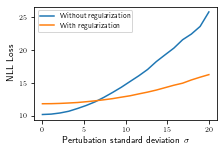

In [64]:
from rbi.visualization.robustness_eval_plots import plot_metric_for_pertubation_scales

scales = torch.linspace(0, 20, 20)
fig = plot_metric_for_pertubation_scales(scales, [m1,m2], test_loader2, figsize=(3,2), legend_names=["Without regularization", "With regularization"], xlabel=r"Pertubation standard deviation $\sigma$")
#fig.savefig("pertubation_resistance.svg")

In [76]:
_, test_loader3 = get_datasets("hudgin_huxley_inverse", N_train=10, N_test=500, batch_size=100)

In [77]:
m1 = EmpiricalAdversarialTestLossMetric(net, LinfPGDAttack(net, adversarial_loss3, nb_iter=1, eps_iter=20.), loss_fn)
m2 = EmpiricalAdversarialTestLossMetric(net2, LinfPGDAttack(net2, adversarial_loss3, nb_iter=1, eps_iter=20.), loss_fn)

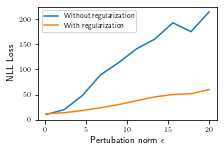

In [78]:
scales = torch.linspace(0.1, 20, 10)
fig = plot_metric_for_pertubation_scales(scales, [m1,m2], test_loader3, figsize=(3,2), legend_names=["Without regularization", "With regularization"], xlabel=r"Pertubation norm $\epsilon$")

In [79]:
fig.savefig("pgd_robustness.svg")